# Modelo de riesgos competitivos

Paquetes:

In [2]:
#Utils
import h5py
import matplotlib.pyplot as plt
import sys

#Numeric
import numpy as np

#Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

#ownimport sys
sys.path.append('/home/jmalagont/Documentos/MLDS6project/src/nombre_paquete/training')
import survivalflow as sf

Rutas importantes:

In [13]:
DataSetPath = '/home/jmalagont/Documentos/MLDS6project/src/dataset/TCGA-BRCA.h5'
BestModelPath = '/home/jmalagont/Documentos/MLDS6project/src/dataset/Best model'

# 1. Carga de datos

In [4]:
DataSet = h5py.File(DataSetPath,'r+') 
Labels = np.abs(np.array([DataSet['time'], np.array(DataSet['status'])+1]).T)
features = np.array(DataSet['embedding'])

X_train, X_test, Y_train, Y_test = train_test_split(features, Labels, test_size=0.3, random_state=42)

print('Entrenamiento\n==============')
print(f'{len(X_train)} Observaciones, tiempos [{np.min(Y_train[:,0])},{np.max(Y_train[:,0])}]')
print('Test\n==============')
print(f'{len(X_test)} Observaciones, tiempos [{np.min(Y_test[:,0])},{np.max(Y_test[:,0])}]')

Entrenamiento
726 Observaciones, tiempos [0,12205]
Test
312 Observaciones, tiempos [0,13132]


# 2. Modelo

In [5]:
def loss(labels, hazards):
  l = sf.CompetingLogNegativePartialLikelihood(labels, hazards,tf.constant([.2,.8],tf.float64))
  return(l)

In [8]:
K.clear_session()

input = Input(shape=(2048))
mid = Dense(1024, activation = 'relu', use_bias = False, kernel_initializer='normal')(input)
out = Dense(2, activation = 'linear', use_bias = False, kernel_initializer='zeros')(mid)

comp = Model(inputs=[input], outputs=[out], name="comp")
comp.compile(optimizer=Adam(learning_rate=0.0001), loss=loss,  metrics=[sf.mean_harrell_index])
comp.summary()

Model: "comp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense (Dense)               (None, 1024)              2097152   
                                                                 
 dense_1 (Dense)             (None, 2)                 2048      
                                                                 
Total params: 2,099,200
Trainable params: 2,099,200
Non-trainable params: 0
_________________________________________________________________


In [9]:
ES = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience = 100)
training_gen = sf.CompetingSurvivalDataGenerator(X_train, Y_train, comp)
test_gen = sf.CompetingSurvivalDataGenerator(X_test, Y_test, comp)

# 3. Entrenamiento

In [10]:
history = comp.fit(x = training_gen, validation_data = test_gen, epochs=100, callbacks = [ES])

Epoch 1/100


2023-06-23 09:08:37.473723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-23 09:08:39.333699: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x555f3240bd10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-23 09:08:39.333715: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-06-23 09:08:39.357401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-23 09:08:39.661786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-23 09:08:39.818

1/1 [==============================] - ETA: 0s - loss: 5.2785 - mean_harrell_index: 0.0000e+00

2023-06-23 09:08:39.923193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 3s 3s/step - loss: 5.2785 - mean_harrell_index: 0.0000e+00 - val_loss: 5.2792 - val_mean_harrell_index: 0.5674
Epoch 2/100
1/1 [==============================] - 0s 465ms/step - loss: 6.2578 - mean_harrell_index: 0.5403 - val_loss: 4.3739 - val_mean_harrell_index: 0.5975
Epoch 3/100
1/1 [==============================] - 0s 461ms/step - loss: 5.3033 - mean_harrell_index: 0.5672 - val_loss: 4.5789 - val_mean_harrell_index: 0.4819
Epoch 4/100
1/1 [==============================] - 0s 461ms/step - loss: 5.5113 - mean_harrell_index: 0.5017 - val_loss: 4.7153 - val_mean_harrell_index: 0.4839
Epoch 5/100
1/1 [==============================] - 0s 462ms/step - loss: 5.6652 - mean_harrell_index: 0.5012 - val_loss: 4.5270 - val_mean_harrell_index: 0.5228
Epoch 6/100
1/1 [==============================] - 0s 473ms/step - loss: 5.5188 - mean_harrell_index: 0.5083 - val_loss: 4.3942 - val_mean_harrell_index: 0.5748
Epoch 7/100
1/1 [============================

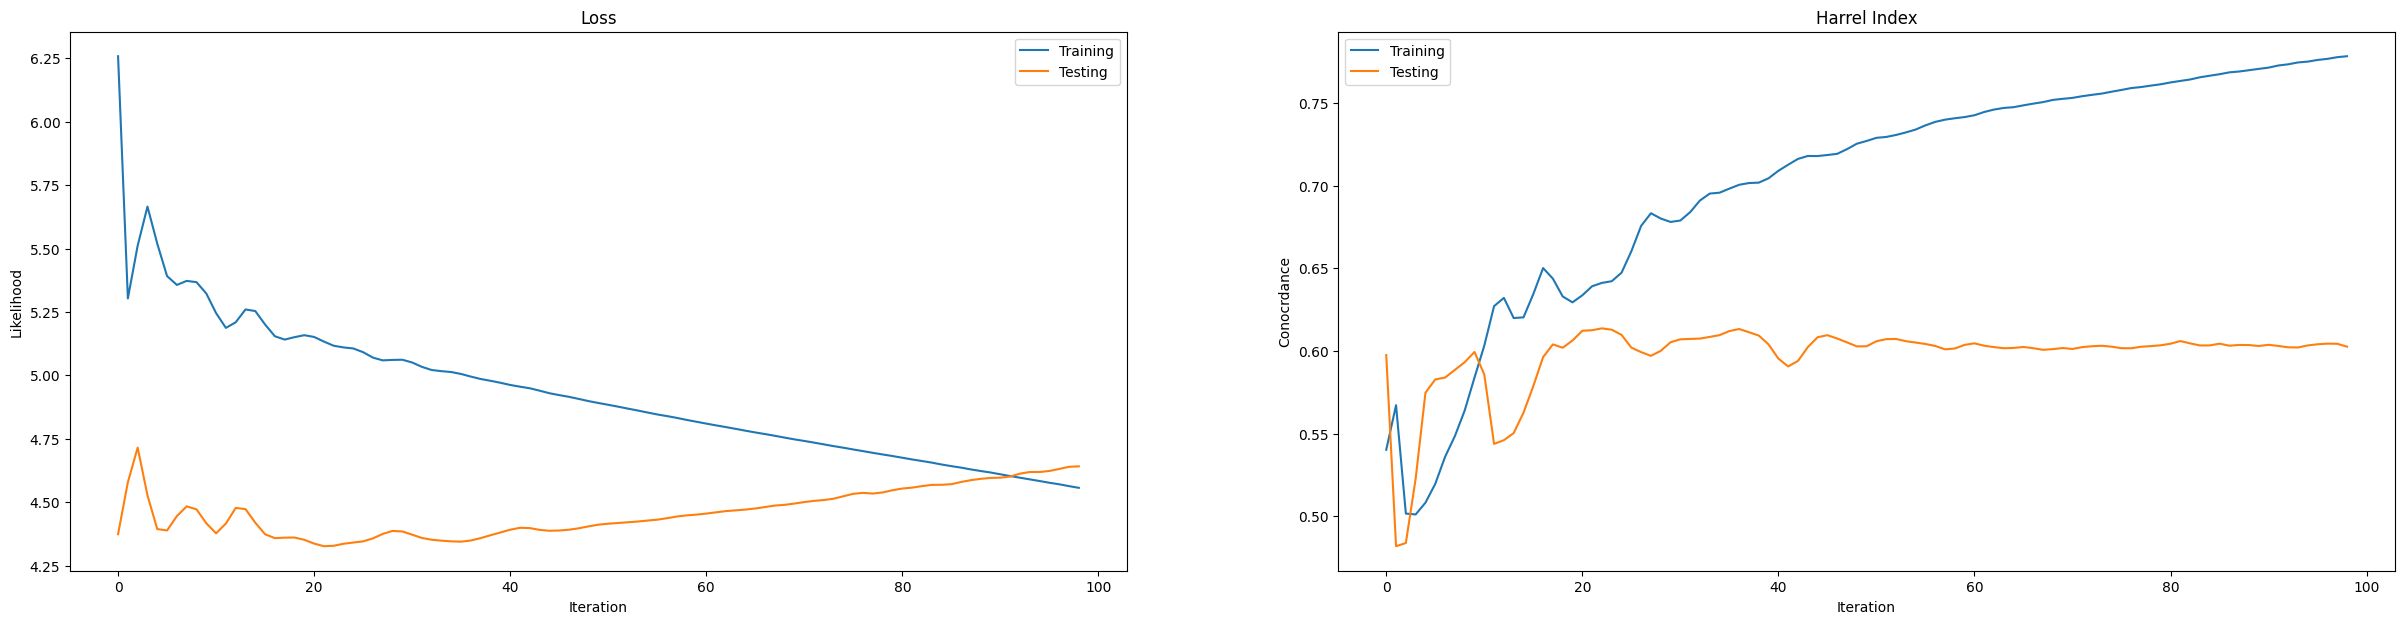

In [11]:
hs = history.history

fig, char = plt.subplots(1,2)
fig.set_size_inches(30, 7)

char[0].plot(hs['loss'][1:], label='Training')
char[0].plot(hs['val_loss'][1:], label='Testing')
char[0].set_title('Loss')
char[0].set_xlabel('Iteration')
char[0].set_ylabel('Likelihood')
char[0].legend()

char[1].plot(hs['mean_harrell_index'][1:], label='Training')
char[1].plot(hs['val_mean_harrell_index'][1:], label='Testing')
char[1].set_title('Harrel Index')
char[1].set_xlabel('Iteration')
char[1].set_ylabel('Conocrdance')
char[1].legend()

plt.show()

# 4. Evaluación

In [12]:
score = comp.evaluate(test_gen, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.641427516937256
Test accuracy: 0.6026221513748169


2023-06-23 09:10:06.809911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [14]:
comp.save(f'{BestModelPath}/modelo.h5')
comp.save_weights(f'{BestModelPath}/pesos.h5')